# Data Pre Processing #

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [5]:
df1 = pd.read_csv("PR_audacity_combined.csv")
df2 = pd.read_csv("PR_jabref_combined.csv")
df3 = pd.read_csv("PR_powertoys_combined.csv")

df1['repo'] = 1
df2['repo'] = 2
df3['repo'] = 3

#combine all the data
df = pd.concat([df1, df2, df3])

In [6]:
df.head()

,pr_number,created_at,merged_at,author,number_of_comments,number_of_review_comments,number_of_commits,lines_of_code_changed,number_of_files_changed,number_of_reviewers,...,number_of_reviews_requested,number_of_revisions,number_of_milestones,dependency_changes,comment_authors,issue_comments_text,review_comments_text,reviews_text,issue_text,repo
0,7308,2024-09-10T13:07:38Z,2024-09-10T13:49:46Z,igorkorsukov,0,0,1,9,2,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1
1,7303,2024-09-10T12:15:27Z,2024-09-10T12:42:48Z,igorkorsukov,0,0,1,9,1,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1
2,7301,2024-09-10T10:27:20Z,2024-09-10T13:13:54Z,grliszas14,0,0,2,40,1,1,...,0,2,0,False,[],NaN,NaN,NaN,Resolves: https://github.com/audacity/audacity...,1
3,7288,2024-09-09T13:13:46Z,2024-09-09T14:53:04Z,LWinterberg,0,0,1,12,3,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1
4,7295,2024-09-10T08:53:37Z,2024-09-10T09:58:23Z,grliszas14,0,0,1,2,1,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1


In [7]:
#reviews_text are also comments
# add the test from the two columns together

df['issue_comments_text'] = (
    df['issue_comments_text'].fillna('').astype(str) + 
    df['reviews_text'].fillna('').astype(str)
)
df.drop(columns=['reviews_text'], inplace=True)


In [8]:
#renaming fro easier use
df['review_comments']=df['review_comments_text']
df.drop(['review_comments_text'], axis=1, inplace=True)


In [9]:
#if comment_author isnt empty list then set comments to 1 else 0
df['comments'] = df['comment_authors'].apply(lambda x: 0 if x.count("'")==0 else 1)

#if comment_author isnt empty then count teh number of apostrophes an d divide that by 2 to get the number of comments as an integer
df['comment_author_number'] = df['comment_authors'].apply(lambda x: 0 if pd.isnull(x) else int(x.count("'")/2))

#count words in issue comments text only if df[comments] ==1 else put 0
df['issue_text_wordiness'] = df['issue_text'].apply(lambda x: 0 if pd.isnull(x) else len(x.split())) 

In [10]:
#count words in issue comments text only if df[comments] ==1 else put 0
df['issue_text_wordiness'] = df['issue_text'].apply(lambda x: 0 if pd.isnull(x) else len(x.split())) 

In [11]:
#count words in issue comments text only if df[comments] ==1 else put 0
df['issue_comments_text_length'] = df['issue_comments_text'].apply(lambda x: 0 if pd.isnull(x) else len(x.split())) 

#now calcualte wordiness by dividing the number of words by the number of comments
df['issue_comments_text_wordiness'] = (df['issue_comments_text_length']/df['comment_author_number'])

#df.drop('issue_comments_text_length', inplace=True, axis=1)

In [12]:
# drop time_since_last_commit and test_coverage columns
df.drop(['time_since_last_commit', 'test_coverage','dependency_changes', 'number_of_linked_issues', 'number_of_milestones'], axis=1, inplace=True)

#divide review_duration and time to first reponse  by 3600 to get hours
df['review_duration'] = df['review_duration']/3600
df['time_to_first_response'] = df['time_to_first_response']/3600


In [13]:
#fill out the missing values with 0
df['time_to_first_response'] = df['time_to_first_response'].fillna(0)

#drop comment_authors column
df.drop(['comment_authors'], axis=1, inplace=True)


In [14]:
df['code_changes_ratio'] = df['lines_of_code_changed'] / df['number_of_files_changed']

#if code_changes_ratio is nan fill with 0
df['code_changes_ratio'] = df['code_changes_ratio'].fillna(0)


In [15]:
#list all teh unique lebales as well as acount for each
labels_all = df['labels'].unique()

#replace [ or ] with empty string from labels_all
labels_all = str(labels_all)
labels_all = labels_all.replace('[',',').replace(']',',')

#replace double speech marks with a comma 
labels_all = labels_all.replace('" "', '')

#remove all the speech marks
labels_all = labels_all.replace('"', '')

#remove the first comma
labels_all = labels_all[3:]

#remove apostrophes and new lines and spaces
labels_all = labels_all.replace("'", "").replace("\n", "").replace(" ", "")

#removve double commas
labels_all = labels_all.replace(',,', ",")

#now ceate a list of all the labels that are unique
labels_all = labels_all.split(',')

#remove any empty strings
labels_all = list(filter(None, labels_all))

#remove duplicates
labels_all = list(dict.fromkeys(labels_all))



In [16]:
#Count number of labels
df['labels_count'] = df['labels'].apply(lambda x: 0 if pd.isnull(x) else int(x.count("'")/2))

#create a column for each label and set it to 1 if the label is present in the labels column
for label in labels_all:
    df[label] = df['labels'].apply(lambda x: 1 if label in str(x) else 0)
    
#drop the original labels column
df.drop(['labels'], axis=1, inplace=True)
    

/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/4029804119.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = df['labels'].apply(lambda x: 1 if label in str(x) else 0)
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/4029804119.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = df['labels'].apply(lambda x: 1 if label in str(x) else 0)
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/4029804119.py:6: PerformanceWarning: DataFrame is highly fragmented.  Thi

In [17]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['merged_at'] = pd.to_datetime(df['merged_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['Issue_Lifetime(hours)'] = (df['merged_at'] - df['created_at']).dt.total_seconds() / 3600


# Define the conditions for the 'Issue Lifetime' groups
conditions = [
    (df['Issue_Lifetime(hours)'] < 1),  # less than 1 hour - group 1
    (df['Issue_Lifetime(hours)'] >= 1) & (df['Issue_Lifetime(hours)'] < 24), # between 1 hour and 1 days - group 2
    (df['Issue_Lifetime(hours)'] >= 24) & (df['Issue_Lifetime(hours)'] < 168),  # between 1 day1 and a week - group 3
    (df['Issue_Lifetime(hours)'] >= 168) & (df['Issue_Lifetime(hours)'] < 5040),  # between  week and a month - group 4
    (df['Issue_Lifetime(hours)'] >= 5040)  # more than a month - group 5
]

# Define the corresponding group numbers
groups = [1, 2, 3, 4, 5]
group_dict={
    1: 'Less than 1 hour',
    2: 'Between 1 hour and 1 day',
    3: 'Between 1 day and a week',
    4: 'Between a week and a month',
    5: 'More than a month'
}

# Create the 'Issue Lifetime' column using np.select
df['Issue Lifetime'] = np.select(conditions, groups)

/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/1279693152.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Issue_Lifetime(hours)'] = (df['merged_at'] - df['created_at']).dt.total_seconds() / 3600
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/1279693152.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Issue Lifetime'] = np.select(conditions, groups)


## Data Distribution ##

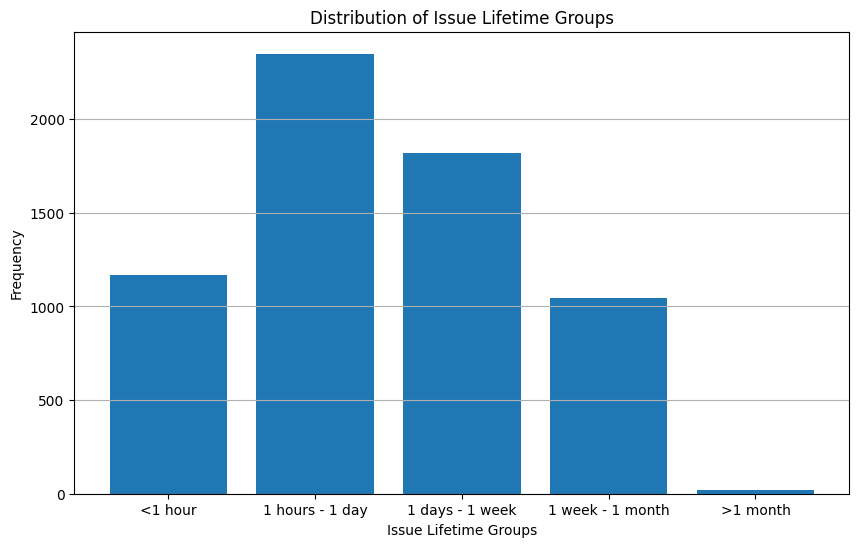

In [18]:
# Graphing the distribution of the groups
group_counts = df['Issue Lifetime'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(group_counts.index, group_counts.values, tick_label=['<1 hour','1 hours - 1 day', '1 days - 1 week', '1 week - 1 month','>1 month'])
plt.title('Distribution of Issue Lifetime Groups')
plt.xlabel('Issue Lifetime Groups')
plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

In [19]:
import pandas as pd

# Ensure 'created_at' and 'merged_at' are in datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['merged_at'] = pd.to_datetime(df['merged_at'])

# Calculate 'Issues Opened in Last 2 Weeks' for each row
df['Issues Opened in Last 2 Weeks'] = df.apply(
    lambda row: df[(df['created_at'] >= row['created_at'] - pd.Timedelta(days=14)) & 
                   (df['created_at'] < row['created_at'])].shape[0], axis=1
)

# Calculate 'Issues Closed in Last 2 Weeks' for each row
df['Issues Closed in Last 2 Weeks'] = df.apply(
    lambda row: df[(df['merged_at'] >= row['merged_at'] - pd.Timedelta(days=14)) & 
                   (df['merged_at'] < row['merged_at'])].shape[0], axis=1
)

# Calculate 'Open PRs at Open Date' for each row
df['Open PRs at Open Date'] = df.apply(
    lambda row: df[(df['created_at'] < row['created_at']) & 
                   (df['merged_at'] > row['created_at'])].shape[0], axis=1
)


/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/2401322557.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Issues Opened in Last 2 Weeks'] = df.apply(
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/2401322557.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Issues Closed in Last 2 Weeks'] = df.apply(
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/2401322557.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

In [20]:
# Calculate the number of PRs opened by the author before each PR's created_at date
df['Author PRs Opened'] = df.apply(
    lambda row: df[(df['author'] == row['author']) & 
                   (df['created_at'] < row['created_at'])].shape[0], axis=1
)


/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/2155083328.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Author PRs Opened'] = df.apply(


In [21]:
#determien teh day ofthe week teh PR was created
df['day_of_week'] = df['created_at'].dt.dayofweek
#0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday

#for df['weekday'] set to 1 if day_of_week is between 0 and 4 else 0
df['weekday'] = df['day_of_week'].apply(lambda x: 1 if x >= 0 and x <= 4 else 0)

/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/2111001302.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['day_of_week'] = df['created_at'].dt.dayofweek
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/2111001302.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weekday'] = df['day_of_week'].apply(lambda x: 1 if x >= 0 and x <= 4 else 0)


In [22]:
#check if the PR was created between 4pm and 9pm
#this si the period in time that most people are working across the US
df['working_hours'] = df['created_at'].dt.hour.apply(lambda x: 1 if x >= 9 and x <= 21 else int(0))


/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_95164/954217661.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['working_hours'] = df['created_at'].dt.hour.apply(lambda x: 1 if x >= 9 and x <= 21 else int(0))


In [23]:
#drop the created_at and merged_at columns and author
df.drop(['created_at', 'merged_at','author'], axis=1, inplace=True)

## Correlation Matrix ##

In [24]:
# Replace empty strings or invalid values with NaN
df.replace('', np.nan, inplace=True)

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
correlation_matrix


,pr_number,number_of_comments,number_of_review_comments,number_of_commits,lines_of_code_changed,number_of_files_changed,number_of_reviewers,number_of_approvals,time_to_first_response,number_of_assignees,...,FancyZones-VirtualDesktop,Issue_Lifetime(hours),Issue Lifetime,Issues Opened in Last 2 Weeks,Issues Closed in Last 2 Weeks,Open PRs at Open Date,Author PRs Opened,day_of_week,weekday,working_hours
pr_number,1.000000,0.085168,-0.029047,0.040569,-0.006060,-0.005942,0.186796,0.209815,-0.033324,-0.118354,...,-0.002662,0.013675,0.101545,0.444848,0.455324,0.445254,0.017349,0.000810,0.009080,0.065295
number_of_comments,0.085168,1.000000,0.509010,0.422821,0.026334,0.039228,0.392401,0.126086,0.044665,0.066609,...,-0.003542,0.311342,0.402373,-0.031200,0.000796,0.037543,-0.093085,0.083605,-0.090661,0.011269
number_of_review_comments,-0.029047,0.509010,1.000000,0.412476,0.021391,0.043226,0.552937,0.070211,0.066844,0.086673,...,-0.002769,0.259776,0.400850,-0.092447,-0.055840,-0.014918,-0.113790,0.075123,-0.042355,0.003569
number_of_commits,0.040569,0.422821,0.412476,1.000000,0.058514,0.103434,0.301520,0.036648,0.041733,0.016995,...,-0.000739,0.214953,0.229923,-0.004561,0.020212,0.003533,-0.025760,0.074280,-0.052235,-0.018053
lines_of_code_changed,-0.006060,0.026334,0.021391,0.058514,1.000000,0.886776,0.033719,0.004292,0.001521,0.024279,...,-0.000534,0.007724,0.015378,-0.023427,-0.025382,0.015130,-0.013130,0.016785,-0.023258,0.007610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Open PRs at Open Date,0.445254,0.037543,-0.014918,0.003533,0.015130,0.020457,0.074083,0.117327,-0.008723,0.171027,...,-0.011133,0.007453,0.095476,0.574492,0.520963,1.000000,0.281913,-0.092777,0.038572,0.094679
Author PRs Opened,0.017349,-0.093085,-0.113790,-0.025760,-0.013130,0.002520,-0.125892,-0.034057,0.012292,0.265815,...,-0.007007,-0.052101,-0.175495,0.305867,0.286801,0.281913,1.000000,-0.111337,0.042310,0.116154
day_of_week,0.000810,0.083605,0.075123,0.074280,0.016785,0.027184,0.070814,-0.006915,0.006639,0.007800,...,-0.002068,0.050886,0.180393,-0.081607,-0.074059,-0.092777,-0.111337,1.000000,-0.672752,-0.017185
weekday,0.009080,-0.090661,-0.042355,-0.052235,-0.023258,-0.032290,-0.027610,0.045771,0.001458,0.016988,...,0.004896,-0.032748,-0.111613,0.024520,0.023274,0.038572,0.042310,-0.672752,1.000000,0.019613


# Random Forrest

In [27]:
# Replace empty strings or invalid values with NaN
df.replace('', np.nan, inplace=True)

# Prepare features and target variable
target = df['Issue Lifetime']  # This will be treated as a classification target
features = df.drop(['Issue Lifetime', 'Issue_Lifetime(hours)'], axis=1, errors='ignore')

# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Check and replace inf and NaN values
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.fillna(0, inplace=True)  # Replace NaN with 0 (or use mean/median if preferred)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [28]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)


Accuracy Score: 0.7665886026541764
Confusion Matrix:
 [[183  45   4   1   0]
 [  4 433  44   2   0]
 [  1  80 266  26   0]
 [  1  19  67 100   0]
 [  0   1   0   4   0]]
Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.79      0.87       233
           2       0.75      0.90      0.82       483
           3       0.70      0.71      0.71       373
           4       0.75      0.53      0.62       187
           5       0.00      0.00      0.00         5

    accuracy                           0.77      1281
   macro avg       0.63      0.59      0.60      1281
weighted avg       0.77      0.77      0.76      1281

Feature Importances:
 review_duration                                                                                                                                                                                                                                                                                        

/Users/atu/Documents/TTS/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/atu/Documents/TTS/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/atu/Documents/TTS/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

## Getting rid of predictors that have a weak correlation

In [38]:
# Get the correlations with 'review_duration'
review_duration_corr = correlation_matrix['Issue_Lifetime(hours)']

# Define a threshold for strong correlation (e.g., |correlation| > 0.2)
threshold = 0.20

# Filter the correlations that are above the threshold
strong_correlations = review_duration_corr[review_duration_corr.abs() > threshold].sort_values(ascending=False)

# Remove self-correlation
strong_correlations = strong_correlations.drop(labels=['Issue_Lifetime(hours)'])

# Display the strong correlations
print("Strong Correlations with 'Issue_Lifetime(hours)':\n", strong_correlations)

# Extract the columns that have strong correlations
strong_corr_columns = strong_correlations.index.tolist()

# Create a DataFrame with these columns
df_strong_corr = df[strong_corr_columns]

#df_strong_corr

Strong Correlations with 'Issue_Lifetime(hours)':
 time_to_first_response           0.451607
Issue Lifetime                   0.397888
number_of_comments               0.311342
review_duration                  0.308084
issue_comments_text_length       0.296334
number_of_review_comments        0.259776
comment_author_number            0.251680
issue_comments_text_wordiness    0.239864
number_of_commits                0.214953
number_of_revisions              0.214953
Name: Issue_Lifetime(hours), dtype: float64


## Enhanced Random Forrest ##

In [39]:
target2 = df_strong_corr['Issue Lifetime']

# features should exclude the target variable
features=df_strong_corr.drop(['Issue Lifetime'], axis=1)


# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Check and replace inf and NaN values
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.fillna(0, inplace=True)  # Replace NaN with 0 (or use mean/median if preferred)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target2, test_size=0.2, random_state=42)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [40]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.8274785323965652
Confusion Matrix:
 [[198  18  12   5   0]
 [ 13 407  50  13   0]
 [  8  26 294  45   0]
 [  1  12  14 160   0]
 [  0   1   0   3   1]]
Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.85      0.87       233
           2       0.88      0.84      0.86       483
           3       0.79      0.79      0.79       373
           4       0.71      0.86      0.77       187
           5       1.00      0.20      0.33         5

    accuracy                           0.83      1281
   macro avg       0.86      0.71      0.73      1281
weighted avg       0.83      0.83      0.83      1281



In [41]:
# Feature importance
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

Feature Importances:
 review_duration                  0.673668
time_to_first_response           0.087547
issue_comments_text_length       0.076857
issue_comments_text_wordiness    0.046300
number_of_review_comments        0.031795
number_of_comments               0.025182
number_of_revisions              0.024668
number_of_commits                0.022927
comment_author_number            0.011053
dtype: float64
